In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder = '../data/raw/odds'
files = os.listdir(folder)
df = pd.DataFrame()
for f in files:
    df_season = pd.read_excel(os.path.join(folder, f))
    df_season['season'] = f.split(' ')[-1].split('.')[0]
    df = pd.concat((df, df_season))

In [3]:
df['Date'] = df['Date'].astype(str)

In [4]:
df['Month'] = df['Date'].apply(lambda x: x[:-2])

In [5]:
df.loc[1328, 'Team'] = 'LAClippers'
df.loc[1326, 'Team'] = 'OklahomaCity'

In [6]:
df.loc[df['Open']=='pk', 'Open'] = 0
df.loc[df['Open']=='PK', 'Open'] = 0
df.loc[df['Close']=='pk', 'Close'] = 0
df.loc[df['Close']=='PK', 'Close'] = 0

In [7]:
def get_gameid(x):
    if x[1] % 2 == 0:
        id_ = x[1] - 1
    else:
        id_ = x[1]
    
    return x[2][2:4] + str(x[0]) + '_' + str(id_)

In [8]:
df.loc[df['Open'] > 260, 'Open'] = df.loc[df['Open'] > 260, 'Close']

In [9]:
gameids = df[['Date', 'Rot', 'season']].apply(lambda x: get_gameid(x), axis=1)
df['gameID'] = gameids
df.reset_index(0, inplace=True, drop=True)

In [10]:
df.loc[4194, 'Open'] = df.loc[4194, 'Close']
df.loc[16595, 'Close'] = df.loc[16595, 'Open']

In [11]:
df.drop(df.index[df['VH']=='N'], axis=0, inplace=True)
df.reset_index(0, inplace=True, drop=True)

In [12]:
games = df.gameID.unique()

In [13]:
favored_open = []
favored_close = []
spread_open = []
spread_close = []
total_open = []
total_close = []
home_ml = df.loc[df['VH']=='H', 'ML'].values
visitor_ml = df.loc[df['VH']=='V', 'ML'].values
home_team = df.loc[df['VH']=='H', 'Team'].values
visitor_team = df.loc[df['VH']=='V', 'Team'].values
home_score = df.loc[df['VH']=='H', 'Final'].values
visitor_score = df.loc[df['VH']=='V', 'Final'].values
home_box_scores = df.loc[df['VH']=='H', ['1st', '2nd', '3rd', '4th']].values
visitor_box_scores = df.loc[df['VH']=='V', ['1st', '2nd', '3rd', '4th']].values
for game in games:
    df_curr = df[df['gameID']==game]
    favored_open += [df_curr.loc[df_curr['Open'] < 100, 'VH'].values[0]]
    favored_close += [df_curr.loc[df_curr['Close'] < 100, 'VH'].values[0]]
    spread_open += [df_curr.loc[df_curr['Open'] < 100, 'Open'].values[0]]
    spread_close += [df_curr.loc[df_curr['Close'] < 100, 'Close'].values[0]]
    total_open += [df_curr.loc[df_curr['Open'] >= 100, 'Open'].values[0]]
    total_close += [df_curr.loc[df_curr['Close'] >= 100, 'Close'].values[0]]

In [14]:
df_games = pd.DataFrame(index=games)
df_games['home_team'] = home_team
df_games['visitor_team'] = visitor_team
df_games['favored_open'] = favored_open
df_games['favored_close'] = favored_close
df_games['spread_open'] = spread_open
df_games['spread_close'] = spread_close
df_games['total_open'] = total_open
df_games['total_close'] = total_close
df_games['home_ml'] = home_ml
df_games['visitor_ml'] = visitor_ml
df_games['home_score'] = home_score
df_games['visitor_score'] = visitor_score

In [15]:
df_home_scores = pd.DataFrame(home_box_scores, index=games, columns=['H 1st', 'H 2nd', 'H 3rd', 'H 4th'])
df_visitor_scores = pd.DataFrame(visitor_box_scores, index=games, columns=['V 1st', 'V 2nd', 'V 3rd', 'V 4th'])
df_games = pd.concat((df_games, df_home_scores, df_visitor_scores), axis=1)

In [16]:
df_games['open_favored_score'] = df_games['total_open'] / 2 + df_games['spread_open'] / 2
df_games['open_underdog_score'] = df_games['total_open'] / 2 - df_games['spread_open'] / 2
df_games['close_favored_score'] = df_games['total_close'] / 2 + df_games['spread_close'] / 2
df_games['close_underdog_score'] = df_games['total_close'] / 2 - df_games['spread_close'] / 2

In [17]:
def get_score_preds(x, team='H'):
    if x[0] == team:
        return x[1]
    else:
        return x[2]

In [18]:
df_games['home_score_open'] = df_games[['favored_open', 'open_favored_score', 'open_underdog_score']].apply(lambda x: get_score_preds(x, 'H'), axis=1)
df_games['visitor_score_open'] = df_games[['favored_open', 'open_favored_score', 'open_underdog_score']].apply(lambda x: get_score_preds(x, 'V'), axis=1)
df_games['home_score_close'] = df_games[['favored_close', 'close_favored_score', 'close_underdog_score']].apply(lambda x: get_score_preds(x, 'H'), axis=1)
df_games['visitor_score_close'] = df_games[['favored_close', 'close_favored_score', 'close_underdog_score']].apply(lambda x: get_score_preds(x, 'V'), axis=1)

In [19]:
games = df[df['Month'].isin(['11', '12', '1', '2', '3'])].gameID.unique()

In [20]:
df_games = df_games.loc[games]

In [21]:
df_games

,home_team,visitor_team,favored_open,favored_close,spread_open,spread_close,total_open,total_close,home_ml,visitor_ml,...,V 3rd,V 4th,open_favored_score,open_underdog_score,close_favored_score,close_underdog_score,home_score_open,visitor_score_open,home_score_close,visitor_score_close
131101_701,Orlando,NewOrleans,V,V,4.0,4.0,194.5,193.5,155,-175,...,25,30,99.25,95.25,98.75,94.75,95.25,99.25,94.75,98.75
131101_703,Charlotte,Cleveland,V,V,1.5,3.5,190.5,188.0,145,-165,...,17,18,96.00,94.50,95.75,92.25,94.50,96.00,92.25,95.75
131101_705,Washington,Philadelphia,H,H,8.5,9.5,196.5,201.0,-530,405,...,30,35,102.50,94.00,105.25,95.75,102.50,94.00,105.25,95.75
131101_707,Atlanta,Toronto,H,H,3.5,3.5,194.0,195.0,-160,140,...,29,27,98.75,95.25,99.25,95.75,98.75,95.25,99.25,95.75
131101_709,Boston,Milwaukee,H,H,2.5,2.5,191.0,185.5,-140,120,...,24,34,96.75,94.25,94.00,91.50,96.75,94.25,94.00,91.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19310_545,GoldenState,LAClippers,V,V,12.5,12.5,226.5,223.5,575,-850,...,35,20,119.50,107.00,118.00,105.50,107.00,119.50,105.50,118.00
19311_547,Atlanta,NewYork,H,H,4.0,5.5,230.0,232.5,-250,200,...,29,22,117.00,113.00,119.00,113.50,117.00,113.00,119.00,113.50
19311_549,Philadelphia,Detroit,H,H,11.0,12.0,215.0,209.5,-800,550,...,29,22,113.00,102.00,110.75,98.75,113.00,102.00,110.75,98.75
19311_551,Miami,Charlotte,H,H,10.0,11.0,211.5,206.5,-700,500,...,28,22,110.75,100.75,108.75,97.75,110.75,100.75,108.75,97.75


In [22]:
df_games.to_csv('../data/transformed/processed_odds.csv')

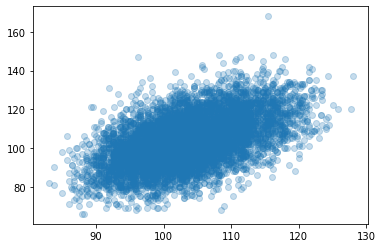

In [30]:
plt.scatter(df_games['visitor_score_close'], df_games['visitor_score'], alpha=0.25)

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error

In [33]:
r2_score(df_games['visitor_score'], df_games['visitor_score_close'])

0.2750113505062498

In [26]:
mean_absolute_error(df_games['home_score_close'], df_games['home_score'])

8.467078329694322

In [27]:
mean_absolute_error(df_games['home_score_open'], df_games['home_score'])

8.583889772106987

In [28]:
mean_absolute_error(df_games['visitor_score_close'], df_games['visitor_score'])

8.590645469432314

In [29]:
mean_absolute_error(df_games['visitor_score_open'], df_games['visitor_score'])

8.672319289028383

In [11]:
df_train = df_data[:-1000]
df_test = df_data[-1000:]

In [18]:
df

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H,season,Month,gameID
0,1029,501,V,Orlando,18,26,20,23,87,187,188.5,675,94.5,2013-14,10,131029_501
1,1029,502,H,Indiana,23,17,29,28,97,12.5,12,-1025,9.5,2013-14,10,131029_501
2,1029,503,V,Chicago,15,18,25,37,95,187.5,188.5,180,3.5,2013-14,10,131029_503
3,1029,504,H,Miami,17,37,24,29,107,5,5,-220,93.5,2013-14,10,131029_503
4,1029,505,V,LAClippers,30,27,22,24,103,9,9.5,-575,5.5,2013-14,10,131029_505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18039,1006,708,N,Miami,22,25,23,26,96,219.5,218,270,106.5,2019-20,10,191006_707
18040,1009,709,N,Miami,25,35,28,23,111,217,215,280,105,2019-20,10,191009_709
18041,1009,710,N,LALakers,24,32,26,26,108,7.5,7,-340,6.5,2019-20,10,191009_709
18042,1011,711,N,LALakers,28,36,23,19,106,5,5.5,-250,104,2019-20,10,191011_711
